In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')

# 2. CODIFICACIÓN CATEGÓRICA (One-Hot Encoding)
# Transformamos: gender, ever_married, work_type, Residence_type, smoking_status
df_final = pd.get_dummies(df, drop_first=True)

# 3. Separación de datos
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculamos el factor de balanceo nativo para XGBoost (Sanos / Infartos)
ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

print(f"Variables después de One-Hot Encoding: {X_train.columns.tolist()}")

Variables después de One-Hot Encoding: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_ever_smoked', 'smoking_status_never smoked']


Calculando curvas para: Scale Pos Weight...
Calculando curvas para: SMOTE + Tomek...
Calculando curvas para: SMOTE + ENN...
Calculando curvas para: NearMiss...
Calculando curvas para: ADASYN...


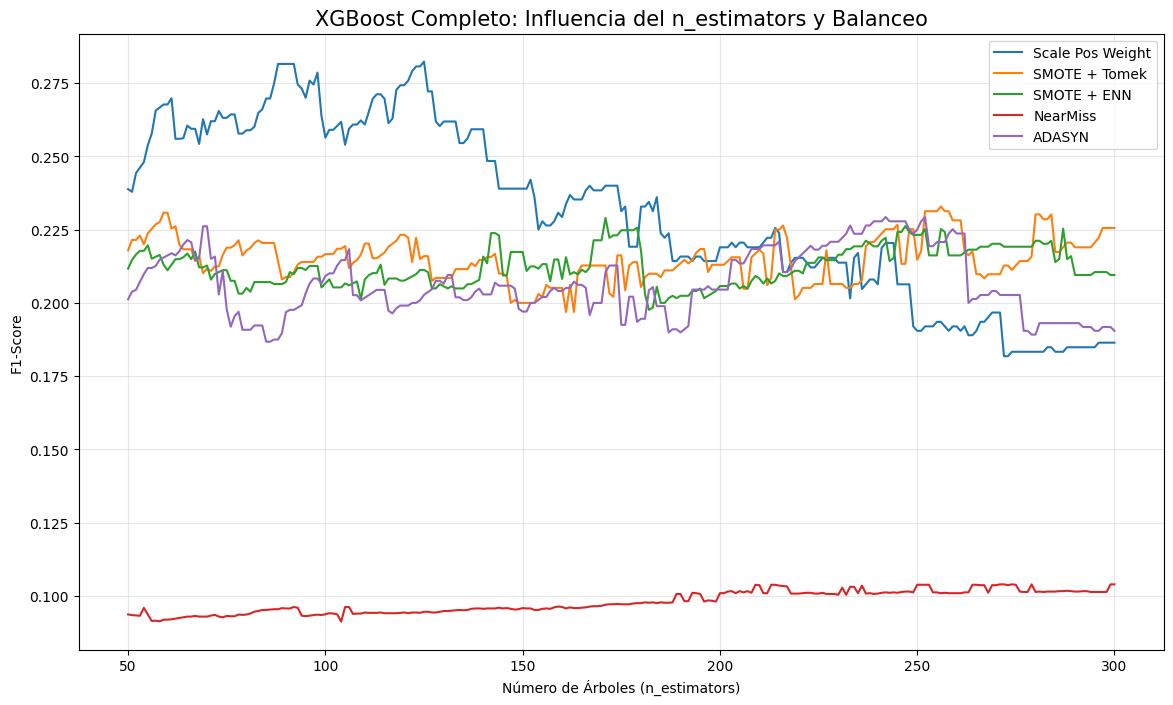


--- RESULTADOS ÓPTIMOS (FASE 1) ---
Técnica: Scale Pos Weight | Mejor n: 125 | F1: 0.2824
Técnica: SMOTE + Tomek    | Mejor n: 256 | F1: 0.2329
Técnica: SMOTE + ENN      | Mejor n: 171 | F1: 0.2290
Técnica: NearMiss         | Mejor n: 271 | F1: 0.1040
Técnica: ADASYN           | Mejor n: 242 | F1: 0.2293


In [2]:
# Rango de 50 a 300 árboles
n_range = range(50, 301)
tecnicas = {
    'Scale Pos Weight': None,  # Técnica nativa de XGBoost
    'SMOTE + Tomek': SMOTETomek(random_state=42),
    'SMOTE + ENN': SMOTEENN(random_state=42),
    'NearMiss': NearMiss(),
    'ADASYN': ADASYN(random_state=42)
}

results = []
plt.figure(figsize=(14, 8))

for nombre, sampler in tecnicas.items():
    f1_scores = []
    
    # Preparar el balanceo
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1 # Ya balanceado, no aplicamos peso extra
        
    print(f"Calculando curvas para: {nombre}...")
    
    for n in n_range:
        model = XGBClassifier(
            n_estimators=n,
            learning_rate=0.1,  # Fijamos una tasa de aprendizaje inicial
            max_depth=5,        # Profundidad estándar inicial
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
    
    plt.plot(n_range, f1_scores, label=nombre)
    
    mejor_f1 = max(f1_scores)
    mejor_n = list(n_range)[f1_scores.index(mejor_f1)]
    results.append({'Técnica': nombre, 'Mejor n': mejor_n, 'F1': mejor_f1})

plt.title('XGBoost Completo: Influencia del n_estimators y Balanceo', fontsize=15)
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- RESULTADOS ÓPTIMOS (FASE 1) ---")
for r in results:
    print(f"Técnica: {r['Técnica']:<16} | Mejor n: {r['Mejor n']:>3} | F1: {r['F1']:.4f}")